In [1]:
#goal of this project is to predict which region a specific recipe is coming from
#input list of ingredients and predict with which region the resulting taste will be assiciated

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
#load data as list of lists
with open('srep00196-s3.csv', 'r')  as f:
    raw_df=[]
    for rownum, row in enumerate(f):
        if(rownum<4):
            continue
        row=row.strip().split(',')
        raw_df.append([row[0], ' '.join(row[1:])])

raw_df[0]

['African', 'chicken cinnamon soy_sauce onion ginger']

In [4]:
#subsample dataset
from random import randint
#raw_df=[row for row in raw_df if randint(1, 10)==1]
len(raw_df)

56498

In [5]:
df=pd.DataFrame(data=raw_df, columns=['Region', 'Ingredients'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56498 entries, 0 to 56497
Data columns (total 2 columns):
Region         56498 non-null object
Ingredients    56498 non-null object
dtypes: object(2)
memory usage: 882.9+ KB


In [6]:
df.head()

,Region,Ingredients
0,African,chicken cinnamon soy_sauce onion ginger
1,African,cane_molasses ginger cumin garlic tamarind bre...
2,African,butter pepper onion cardamom cayenne ginger co...
3,African,olive_oil pepper wheat beef onion cardamom cum...
4,African,honey wheat yeast


In [7]:
def barplot(ys, labels=[], title=''):
    xs=np.linspace(0, ys.shape[0], ys.shape[0])
    plt.figure(figsize=(20,5))
    plt.bar(xs, ys)
    plt.title(title, fontsize=20)
    plt.xticks(xs, labels, rotation=70, fontsize=20)
    plt.grid()
    plt.show()   

In [8]:
def plot_confusion_matrix(cf, title):
    mask=cf==0
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf, 
                mask=mask,
                annot=True, 
                fmt='g', 
                square=True,
                xticklabels=True,
                linewidths=0.1,
                linecolor='gray',
                center=0, 
                cmap='coolwarm', 
                cbar=False)

    plt.title(title, size=20)
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

(56498, 2)
(112996, 2)


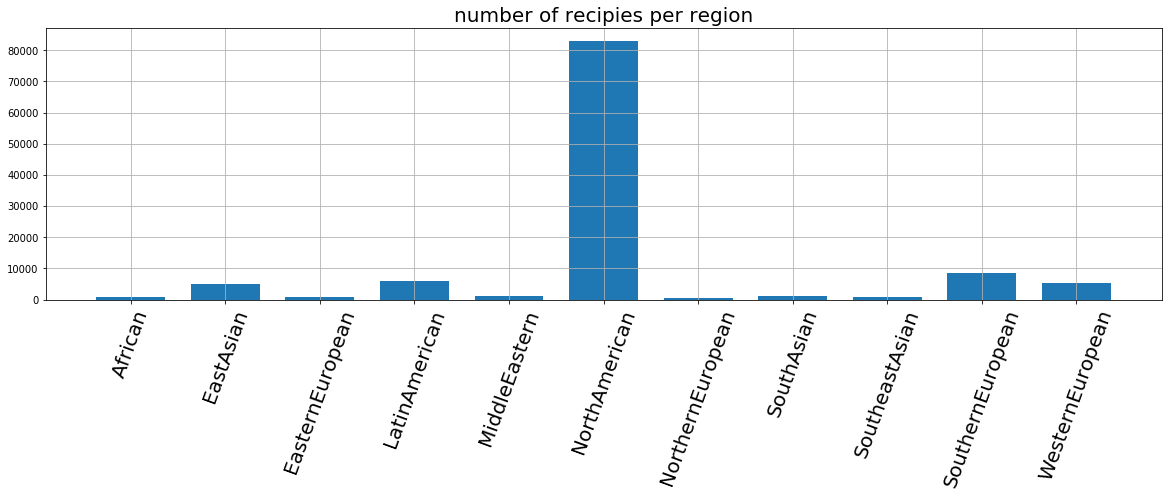

In [9]:
df_orig=df

print(df_orig.shape)

for region in df['Region'].unique():
    region_idx=df['Region']==region
    df_orig=df_orig.append([df[region_idx]], ignore_index=True)

print(df_orig.shape)

region_count_orig=df_orig.groupby('Region').count()
barplot(ys=region_count_orig['Ingredients'],
        labels=region_count_orig.index,
        title='number of recipies per region')

In [10]:
#penalizing NorthAmerica and increasing number of other recipies
print(df.shape)

for region in df['Region'].unique():
    print(region)
    if(region!='NorthAmerican'):
        region_idx=df['Region']==region
        df=df.append([df[region_idx]]*10, ignore_index=True)

df=df.sample(50000)
print(df.shape)



(56498, 2)
African
EastAsian
EasternEuropean
LatinAmerican
MiddleEastern
NorthAmerican
NorthernEuropean
SouthAsian
SoutheastAsian
SouthernEuropean
WesternEuropean
(50000, 2)


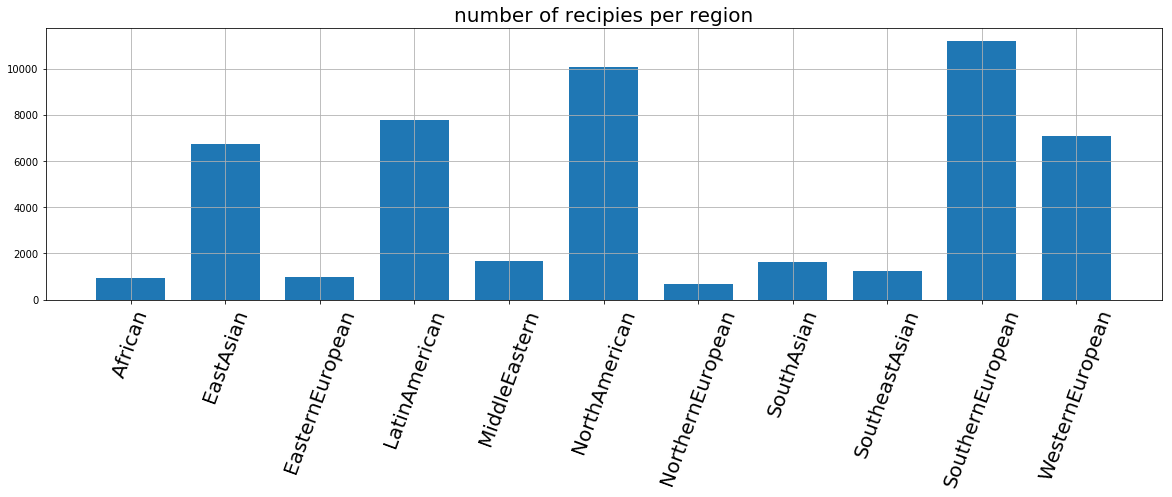

In [11]:
region_count=df.groupby('Region').count()

barplot(ys=region_count['Ingredients'], 
        labels=region_count.index, 
        title='number of recipies per region')

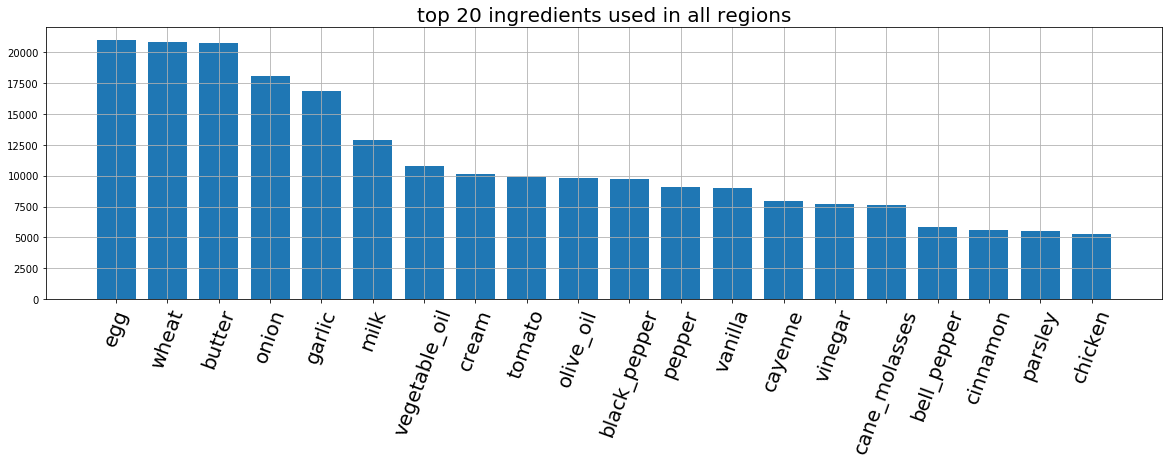

In [12]:
ingredients_per_region=[]

for row in raw_df:
    for ingredient in row[1].split():
        ingredients_per_region.append((row[0], ingredient))
    
df_ingredients_per_region=pd.DataFrame(ingredients_per_region, columns=['Region', 'Ingredient'])
df_ingredients_per_region.head()

top_ingredients=df_ingredients_per_region['Ingredient'].value_counts()[:20]
barplot(top_ingredients, top_ingredients.index, 'top 20 ingredients used in all regions')

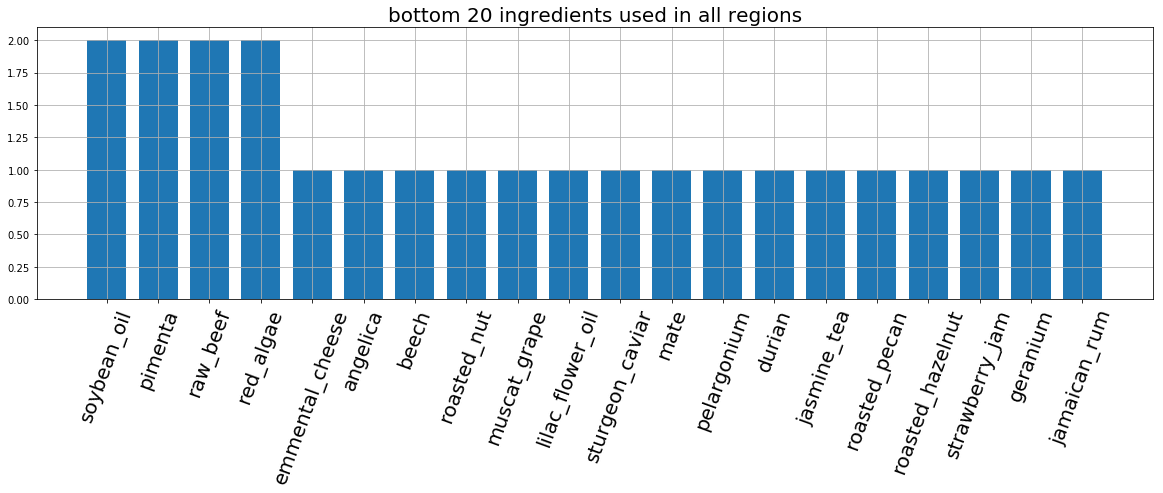

In [13]:
bottom_ingredients=df_ingredients_per_region['Ingredient'].value_counts()[-20:]
barplot(bottom_ingredients, bottom_ingredients.index, 'bottom 20 ingredients used in all regions')

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

cv_ingredients=CountVectorizer()
X_ingredients=cv_ingredients.fit_transform(df['Ingredients'])
ingredients_cv=cv_ingredients.build_analyzer()

In [15]:
from sklearn.preprocessing import LabelEncoder
l_encoder=LabelEncoder()
y_regions=l_encoder.fit_transform(df['Region'])
y_regions.shape

(50000,)

In [16]:
from sklearn.model_selection import train_test_split
X=X_ingredients.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y_regions, test_size=0.3, random_state=5)
#X_train.shape, y_train.shape#, df_region_nums.shape

In [17]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
#df_region_nums=df_region_nums==1
lr_predicted=lr.predict(X_test)

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(classification_report(y_test, lr_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, lr_predicted))

#precision: ratio of how many positive predictions are correct
#recall: ratio of how many positive predictions were missed
#f1: weighted harmonic mean of the precision and recall
#support: number of occurrences of each class in y_true.

                  precision    recall  f1-score   support

         African       0.71      0.42      0.53       294
       EastAsian       0.90      0.92      0.91      2113
 EasternEuropean       0.60      0.21      0.31       295
   LatinAmerican       0.78      0.78      0.78      2305
   MiddleEastern       0.52      0.24      0.33       464
   NorthAmerican       0.54      0.59      0.56      2989
NorthernEuropean       0.58      0.27      0.37       184
      SouthAsian       0.74      0.73      0.73       486
  SoutheastAsian       0.87      0.66      0.75       384
SouthernEuropean       0.71      0.78      0.74      3361
 WesternEuropean       0.53      0.54      0.53      2125

       micro avg       0.68      0.68      0.68     15000
       macro avg       0.68      0.56      0.60     15000
    weighted avg       0.68      0.68      0.68     15000

Accuracy:  0.6838666666666666


In [20]:
df_y_test=pd.DataFrame(data={'region_name':l_encoder.inverse_transform(y_test), 
                             'region_num':y_test})
df_y_test.head()
df_lr_predicted=pd.DataFrame(data={'region_name':l_encoder.inverse_transform(lr_predicted), 
                                   'region_num':lr_predicted})
#df_lr_predicted.head()

In [21]:
lr_cf=confusion_matrix(y_test, lr_predicted)

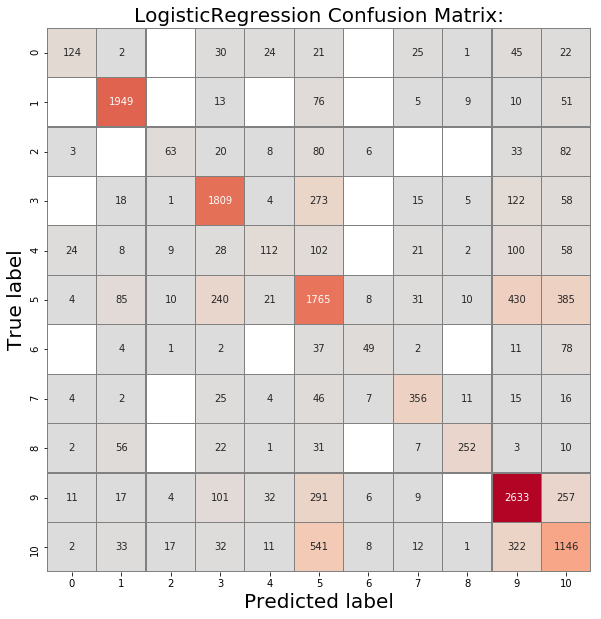

In [22]:
plot_confusion_matrix(lr_cf, 'LogisticRegression Confusion Matrix:')

In [23]:
#hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

estimator_benchm=[]
for num_est in [10, 20, 30, 50, 80, 100]:
    print('num_est: ', num_est)
    rnd_forest=RandomForestClassifier(n_estimators=num_est, random_state=100)
    rnd_forest.fit(X_train, y_train)
    rnd_f_predicted=rnd_forest.predict(X_test)
    estimator_benchm.append((num_est, accuracy_score(y_test, rnd_f_predicted)))
    print(estimator_benchm)

num_est:  10
[(10, 0.8588)]
num_est:  20
[(10, 0.8588), (20, 0.8619333333333333)]
num_est:  30
[(10, 0.8588), (20, 0.8619333333333333), (30, 0.8672666666666666)]
num_est:  50
[(10, 0.8588), (20, 0.8619333333333333), (30, 0.8672666666666666), (50, 0.8671333333333333)]
num_est:  80
[(10, 0.8588), (20, 0.8619333333333333), (30, 0.8672666666666666), (50, 0.8671333333333333), (80, 0.8692)]
num_est:  100
[(10, 0.8588), (20, 0.8619333333333333), (30, 0.8672666666666666), (50, 0.8671333333333333), (80, 0.8692), (100, 0.8698666666666667)]


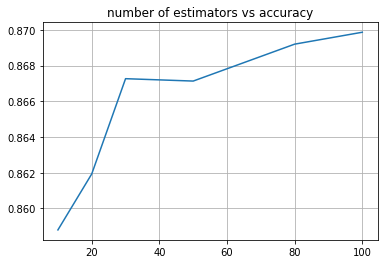

In [24]:
xs=[x[0] for x in estimator_benchm]
ys=[y[1] for y in estimator_benchm]

plt.title('number of estimators vs accuracy')
plt.grid()
plt.plot(xs, ys)

In [25]:
rnd_forest=RandomForestClassifier(n_estimators=80, random_state=100)
rnd_forest.fit(X_train, y_train)
rnd_f_predicted=rnd_forest.predict(X_test)

print(classification_report(y_test, rnd_f_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, rnd_f_predicted))

                  precision    recall  f1-score   support

         African       0.86      0.78      0.82       294
       EastAsian       0.95      0.99      0.97      2113
 EasternEuropean       0.89      0.77      0.82       295
   LatinAmerican       0.89      0.95      0.92      2305
   MiddleEastern       0.82      0.79      0.81       464
   NorthAmerican       0.84      0.66      0.74      2989
NorthernEuropean       0.88      0.80      0.84       184
      SouthAsian       0.87      0.94      0.90       486
  SoutheastAsian       0.94      0.89      0.92       384
SouthernEuropean       0.84      0.94      0.89      3361
 WesternEuropean       0.84      0.87      0.86      2125

       micro avg       0.87      0.87      0.87     15000
       macro avg       0.87      0.85      0.86     15000
    weighted avg       0.87      0.87      0.87     15000

Accuracy:  0.8692


In [26]:
rnd_f_cf=confusion_matrix(y_test, rnd_f_predicted)

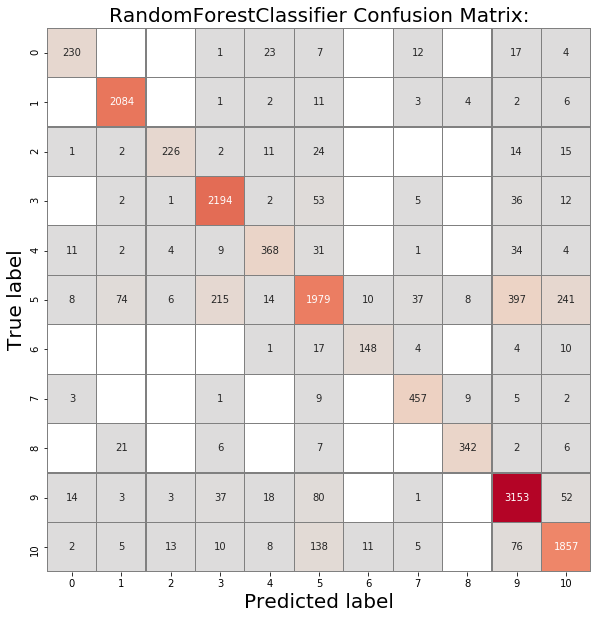

In [27]:
plot_confusion_matrix(rnd_f_cf, 'RandomForestClassifier Confusion Matrix:')

In [28]:
from sklearn.neural_network import MLPClassifier

n_net = MLPClassifier(
                    solver='adam',
                    activation='relu',
                    alpha=1e-5,
                    learning_rate='constant',
                    validation_fraction=0.2,
                    hidden_layer_sizes=(3, 2), 
                    random_state=100,
                    verbose=True, 
                    max_iter=100)

In [29]:
from datetime import datetime
start=datetime.now()
print(start)

n_net.fit(X_train, y_train)

print(datetime.now()-start)

2018-12-22 14:24:24.947274
Iteration 1, loss = 2.59404611
Iteration 2, loss = 2.31706534
Iteration 3, loss = 2.13244698
Iteration 4, loss = 2.02055024
Iteration 5, loss = 1.94114938
Iteration 6, loss = 1.87477864
Iteration 7, loss = 1.81178451
Iteration 8, loss = 1.77008062
Iteration 9, loss = 1.74642485
Iteration 10, loss = 1.72920504
Iteration 11, loss = 1.71494611
Iteration 12, loss = 1.70227823
Iteration 13, loss = 1.69090768
Iteration 14, loss = 1.68011891
Iteration 15, loss = 1.67046211
Iteration 16, loss = 1.66162769
Iteration 17, loss = 1.65383922
Iteration 18, loss = 1.64721933
Iteration 19, loss = 1.64153952
Iteration 20, loss = 1.63647188
Iteration 21, loss = 1.63186418
Iteration 22, loss = 1.62812794
Iteration 23, loss = 1.62436164
Iteration 24, loss = 1.62110714
Iteration 25, loss = 1.61788104
Iteration 26, loss = 1.61491099
Iteration 27, loss = 1.61184807
Iteration 28, loss = 1.60892535
Iteration 29, loss = 1.60557165
Iteration 30, loss = 1.60234829
Iteration 31, loss = 1

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [30]:
n_net_predicted=n_net.predict(X_test)

In [31]:
print(classification_report(y_test, n_net_predicted, target_names=l_encoder.classes_))
print('Accuracy: ', accuracy_score(y_test, n_net_predicted))

                  precision    recall  f1-score   support

         African       0.00      0.00      0.00       294
       EastAsian       0.89      0.79      0.84      2113
 EasternEuropean       0.00      0.00      0.00       295
   LatinAmerican       0.62      0.63      0.62      2305
   MiddleEastern       0.00      0.00      0.00       464
   NorthAmerican       0.26      0.04      0.08      2989
NorthernEuropean       0.00      0.00      0.00       184
      SouthAsian       0.00      0.00      0.00       486
  SoutheastAsian       0.00      0.00      0.00       384
SouthernEuropean       0.40      0.84      0.54      3361
 WesternEuropean       0.32      0.49      0.39      2125

       micro avg       0.47      0.47      0.47     15000
       macro avg       0.23      0.25      0.22     15000
    weighted avg       0.41      0.47      0.41     15000

Accuracy:  0.4746666666666667


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


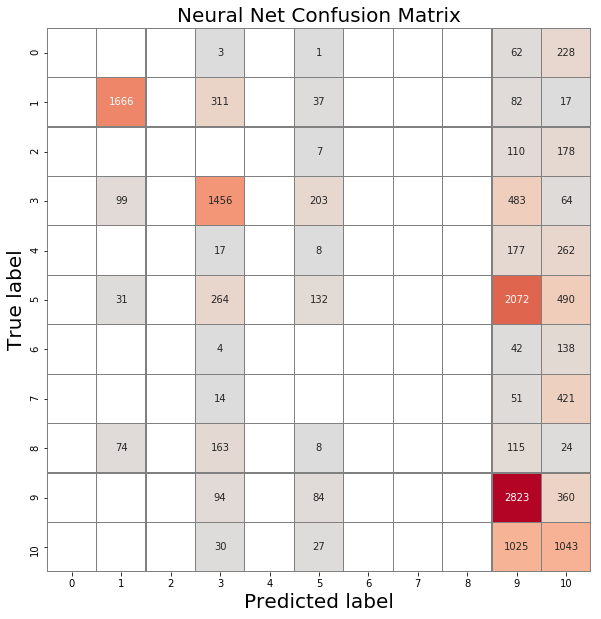

In [32]:
n_net_cf=confusion_matrix(y_test, n_net_predicted)
plot_confusion_matrix(n_net_cf, 'Neural Net Confusion Matrix')

In [33]:
recipies="""sesame_oil mushroom starch ginger bean garlic chicken sake shiitake cayenne scallion bell_pepper vegetable vegetable_oil beef_broth egg soy_sauce  
tomato vinegar celery_oil onion starch corn cayenne ginger shrimp honey garlic bell_pepper vegetable_oil egg     
vinegar mushroom onion beef starch sake tangerine orange_juice black_pepper carrot bell_pepper egg       
vinegar pork onion starch corn black_pepper carrot pineapple shiitake soy_sauce         
wheat starch vegetable_oil squid pineapple egg             
pork sesame_oil starch sake shiitake cayenne ginger scallion garlic bell_pepper vegetable_oil beef_broth soy_sauce      
kelp soybean beef radish soy_sauce black_pepper scallion            
wheat sesame_oil onion starch sake black_pepper soy_sauce cayenne ginger scallion garlic cod soybean vegetable_oil oyster    
pork sesame_oil onion starch shiitake cayenne ginger shrimp bean garlic vegetable_oil soy_sauce oyster pumpkin     
pork sesame_oil starch cayenne shiitake black_pepper scallion carrot nira garlic rice soy_sauce pumpkin      
vinegar starch sake cayenne soy_sauce black_pepper ginger scallion garlic chicken egg        
pork wheat mushroom squid black_pepper ginger carrot garlic vegetable_oil shrimp onion sake soy_sauce cayenne chinese_cabbage scallion vegetable mussel beef_broth
"""

recipies=[recipe.strip().split() for recipe in recipies.split('\n')]
len(recipies)

13

In [34]:
#predict region from ingredients
ft_names=cv_ingredients.get_feature_names()

recipe_vecs=[]
for recipe in recipies:
    ing_vec=np.zeros(X_train.shape[1])
    
    for ingredient in recipe:
        idx=ft_names.index(ingredient)
        ing_vec[idx]=1
    
    recipe_vecs.append(ing_vec)
        
ing_vec=np.array([ing_vec])
recipe_vecs=np.array(recipe_vecs)
print( X_train.shape, recipe_vecs.shape)

(35000, 366) (13, 366)


In [35]:
predicted_lr=lr.predict(recipe_vecs)
print('LogistReg_prediction: ')
for pred_num in predicted_lr:
    print(l_encoder.inverse_transform([pred_num]), pred_num)


rnd_f_predicted=rnd_forest.predict(recipe_vecs)
print('\n\nRND_Forest_prediction: ')
for pred_num in rnd_f_predicted:
  print(l_encoder.inverse_transform([pred_num]), pred_num)

n_net_predicted=n_net.predict(recipe_vecs)
print('\n\nNeural_Net_prediction: ')
for pred_num in n_net_predicted:
  print(l_encoder.inverse_transform([pred_num]), pred_num)


LogistReg_prediction: 
['EastAsian'] 1
['EastAsian'] 1
['WesternEuropean'] 10
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['NorthAmerican'] 5


RND_Forest_prediction: 
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['NorthAmerican'] 5


Neural_Net_prediction: 
['EastAsian'] 1
['NorthAmerican'] 5
['LatinAmerican'] 3
['EastAsian'] 1
['LatinAmerican'] 3
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['EastAsian'] 1
['SouthernEuropean'] 9
